In [20]:
import os
  
# change the current directory 
# to specified directory 
os.chdir(r"/content/drive/My Drive/Project_tasks/classification") 
	
os.getcwd()

'/content/drive/My Drive/Project_tasks/classification'

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134448 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [1]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [2]:
import keras
import tensorflow
import cv2
import pandas as pd
import numpy as np
print(tensorflow.__version__)
print(keras.__version__)
print(cv2.__version__)
print(pd.__version__)
print(np.__version__)


Using TensorFlow backend.


2.0.0
2.2.5
4.1.2
0.25.3
1.17.5


In [5]:
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub

     |████████████████████████████████| 380.8MB 15kB/s 
     |████████████████████████████████| 450kB 55.0MB/s 
     |████████████████████████████████| 3.8MB 52.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [0]:
pd.set_option("display.precision", 8)

In [0]:
data_root='/content/drive/My Drive/Project_tasks/classification/image_class'

In [6]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/Project_tasks/classification/image_class
Found 120 images belonging to 6 classes.
Found 480 images belonging to 6 classes.


In [7]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)
['Artstudio' 'Auditorium' 'Bakery' 'Bar' 'Bathroom' 'Bedroom']


In [8]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Train for 15.0 steps, validate for 4.0 steps
Epoch 1/10
15/15 [==============================] - 76s 5s/step - loss: 1.6532 - acc: 0.3833 - val_loss: 0.7148 - val_acc: 0.8250
Epoch 2/10
15/15 [==============================] - 10s 638ms/step - loss: 0.7252 - acc: 0.7750 - val_loss: 0.3589 - val_acc: 0.9333
Epoch 3/10
15/15 [==============================] - 12s 785ms/step - loss: 0.3928 - acc: 0.8750 - val_loss: 0.2711 - val_acc: 0.9333
Epoch 4/10
15/15 [==============================] - 10s 683ms/step - loss: 0.2723 - acc: 0.9208 - val_loss: 0.2305 - val_acc: 0.9417
Epoch 5/10
15/15 [==============================] - 10s 648ms/step - loss: 0.2755 - acc: 0.9125 - val_loss: 0.2142 - val_acc: 0.9333
Epoch 6/10
15/15 [==============================] - 10s 677ms/step - loss: 0.1991 - acc: 0.9417 - val_loss: 0.2026 - val_acc: 0.9333
Epoch 7/10
15/15 [==============================] - 10s 655ms/step - loss: 0.1742 - acc: 0.9521 - val_loss: 0.1940 - val_acc: 0.9417
Epoch 8/10
15/15 [=========

In [0]:
ROOM_SAVED_MODEL = "saved_models/model_1"
tf.keras.experimental.export_saved_model(model, ROOM_SAVED_MODEL)
room_model = tf.keras.experimental.load_from_saved_model(ROOM_SAVED_MODEL,
custom_objects={'KerasLayer':hub.KerasLayer})

In [12]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [13]:
tf_model_predictions = room_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Artstudio,Auditorium,Bakery,Bar,Bathroom,Bedroom
0,0.00010583,0.00134760,0.00028237,0.99823964,0.00001183,0.00001266
1,0.12980200,0.26523721,0.02767070,0.55745679,0.01708320,0.00275005
2,0.00720073,0.04184791,0.00081804,0.94610137,0.00052520,0.00350668
3,0.89819270,0.00653878,0.02908115,0.02342522,0.03280297,0.00995919
4,0.06196199,0.20743485,0.01106895,0.61075777,0.04999851,0.05877804


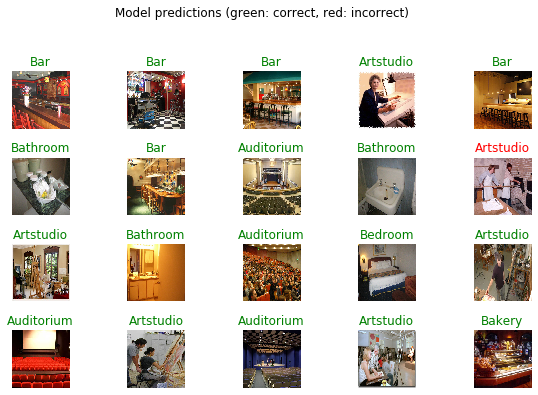

In [15]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
!mkdir "/content/drive/My Drive/Project_tasks/classification/tflite_models"
TFLITE_MODEL = "tflite_models/room.tflite"
TFLITE_QUANT_MODEL = "tflite_models/room_quant.tflite"

In [21]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : room_model(x))
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)
print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 11M
-rw------- 1 root root 2.3M Mar  7 22:40 room_quant.tflite
-rw------- 1 root root 8.5M Mar  7 22:40 room.tflite


In [0]:
val_image_batch
